# Modelo predicción de ventas a nivel semanal

In [1]:
# MANEJO Y ESTRUCTURA DE DATOS

import numpy as np
import pandas as pd
import os
import gc
import warnings
import scipy.stats as stats
import statsmodels.api as sm
import itertools
import random
import nbformat
import pickle



# VISUALIZATION DE DATOS

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# MODELOS PARA SIMULACIÓN DE PRECIOS, TRANSACCIONES Y VENTAS | PRUEBAS DE HIPÓTESIS

from statsmodels.tsa.arima_process import ArmaProcess
from arch import arch_model
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import holidays
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.seasonal import seasonal_decompose


# CONFIGURACIONES

pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format
warnings.filterwarnings('ignore')


In [2]:
# DATASET A IMPORTAR
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
stores = pd.read_csv("stores.csv")
#sub = pd.read_csv("sample_submission.csv")   
transactions = pd.read_csv("transactions.csv").sort_values(["store_nbr", "date"])
oil = pd.read_csv("oil.csv")
holidays = pd.read_csv("holidays_events.csv")


# FECHAS Y HORAS
train["date"] = pd.to_datetime(train.date)
test["date"] = pd.to_datetime(test.date)
transactions["date"] = pd.to_datetime(transactions.date)
holidays["date"] = pd.to_datetime(holidays.date)
oil["date"] = pd.to_datetime(oil.date)


# AJUSTE TIPOS DE DATOS OBJETO A NÚMERICO
train.onpromotion = train.onpromotion.astype("float16")
train.sales = train.sales.astype("float32")
stores.cluster = stores.cluster.astype("int8")

In [3]:
# Días festivos transferidos

tr1 = holidays[(holidays.type == "Holiday") & (holidays.transferred == True)].drop("transferred", axis = 1).reset_index(drop = True)
tr2 = holidays[(holidays.type == "Transfer")].drop("transferred", axis = 1).reset_index(drop = True)
tr = pd.concat([tr1,tr2], axis = 1)
tr = tr.iloc[:, [5,1,2,3,4]]

holidays = holidays[(holidays.transferred == False) & (holidays.type != "Transfer")].drop("transferred", axis = 1)
holidays = holidays.append(tr).reset_index(drop = True)

# Días festivos adicionales
holidays["description"] = holidays["description"].str.replace("-", "").str.replace("+", "").str.replace('\d+', '')
holidays["type"] = np.where(holidays["type"] == "Additional", "Holiday", holidays["type"])

# Días festivos "Puentes"
holidays["description"] = holidays["description"].str.replace("Puente ", "")
holidays["type"] = np.where(holidays["type"] == "Bridge", "Holiday", holidays["type"])

 
# Días festivos trabajados, esto para saldar el puente
work_day = holidays[holidays.type == "Work Day"]  
holidays = holidays[holidays.type != "Work Day"]

# Segmentación de datos

# Eventos Nacionales
events = holidays[holidays.type == "Event"].drop(["type", "locale", "locale_name"], axis = 1).rename({"description":"events"}, axis = 1)

holidays = holidays[holidays.type != "Event"].drop("type", axis = 1)
regional = holidays[holidays.locale == "Regional"].rename({"locale_name":"state", "description":"holiday_regional"}, axis = 1).drop("locale", axis = 1).drop_duplicates()
national = holidays[holidays.locale == "National"].rename({"description":"holiday_national"}, axis = 1).drop(["locale", "locale_name"], axis = 1).drop_duplicates()
local = holidays[holidays.locale == "Local"].rename({"description":"holiday_local", "locale_name":"city"}, axis = 1).drop("locale", axis = 1).drop_duplicates()



d = pd.merge(train.append(test), stores)
d["store_nbr"] = d["store_nbr"].astype("int8")


# Días festivos nacionales & Eventos
#d = pd.merge(d, events, how = "left")
d = pd.merge(d, national, how = "left")
# Regionales
d = pd.merge(d, regional, how = "left", on = ["date", "state"])
# Locales
d = pd.merge(d, local, how = "left", on = ["date", "city"])

# Día Laborales: Serán removidos cuándo la columna real de día laboral sea creada 
d = pd.merge(d,  work_day[["date", "type"]].rename({"type":"IsWorkDay"}, axis = 1),how = "left")


# Eventos
events["events"] = np.where(events.events.str.contains("futbol"), "Futbol", events.events)

def one_hot_encoder(df, nan_as_category=True):
    original_columns = list(df.columns)
    categorical_columns = df.select_dtypes(["category", "object"]).columns.tolist()
    # categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns=categorical_columns, dummy_na=nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    df.columns = df.columns.str.replace(" ", "_")
    return df, df.columns.tolist()

events, events_cat = one_hot_encoder(events, nan_as_category=False)
events["events_Dia_de_la_Madre"] = np.where(events.date == "2016-05-08", 1,events["events_Dia_de_la_Madre"])
events = events.drop(239)

d = pd.merge(d, events, how = "left")
d[events_cat] = d[events_cat].fillna(0)

# Caracteristicas
d["holiday_national_binary"] = np.where(d.holiday_national.notnull(), 1, 0)
d["holiday_local_binary"] = np.where(d.holiday_local.notnull(), 1, 0)
d["holiday_regional_binary"] = np.where(d.holiday_regional.notnull(), 1, 0)

# 
d["national_independence"] = np.where(d.holiday_national.isin(['Batalla de Pichincha',  'Independencia de Cuenca', 'Independencia de Guayaquil', 'Independencia de Guayaquil', 'Primer Grito de Independencia']), 1, 0)
d["local_cantonizacio"] = np.where(d.holiday_local.str.contains("Cantonizacio"), 1, 0)
d["local_fundacion"] = np.where(d.holiday_local.str.contains("Fundacion"), 1, 0)
d["local_independencia"] = np.where(d.holiday_local.str.contains("Independencia"), 1, 0)


holidays, holidays_cat = one_hot_encoder(d[["holiday_national","holiday_regional","holiday_local"]], nan_as_category=False)
d = pd.concat([d.drop(["holiday_national","holiday_regional","holiday_local"], axis = 1),holidays], axis = 1)

he_cols = d.columns[d.columns.str.startswith("events")].tolist() + d.columns[d.columns.str.startswith("holiday")].tolist() + d.columns[d.columns.str.startswith("national")].tolist()+ d.columns[d.columns.str.startswith("local")].tolist()
d[he_cols] = d[he_cols].astype("int8")

d[["family", "city", "state", "type"]] = d[["family", "city", "state", "type"]].astype("category")

del holidays, holidays_cat, work_day, local, regional, national, events, events_cat, tr, tr1, tr2, he_cols
gc.collect()

d.head(10)

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,IsWorkDay,events_Black_Friday,events_Cyber_Monday,events_Dia_de_la_Madre,events_Futbol,events_Terremoto_Manabi,holiday_national_binary,holiday_local_binary,holiday_regional_binary,national_independence,local_cantonizacio,local_fundacion,local_independencia,holiday_national_Batalla_de_Pichincha,holiday_national_Carnaval,holiday_national_Dia_de_Difuntos,holiday_national_Dia_de_la_Madre,holiday_national_Dia_del_Trabajo,holiday_national_Independencia_de_Cuenca,holiday_national_Independencia_de_Guayaquil,holiday_national_Navidad,holiday_national_Primer_Grito_de_Independencia,holiday_national_Primer_dia_del_ano,holiday_national_Viernes_Santo,holiday_regional_Provincializacion_Santa_Elena,holiday_regional_Provincializacion_de_Cotopaxi,holiday_regional_Provincializacion_de_Imbabura,holiday_regional_Provincializacion_de_Santo_Domingo,holiday_local_Cantonizacion_de_Cayambe,holiday_local_Cantonizacion_de_El_Carmen,holiday_local_Cantonizacion_de_Guaranda,holiday_local_Cantonizacion_de_Latacunga,holiday_local_Cantonizacion_de_Libertad,holiday_local_Cantonizacion_de_Quevedo,holiday_local_Cantonizacion_de_Riobamba,holiday_local_Cantonizacion_de_Salinas,holiday_local_Cantonizacion_del_Puyo,holiday_local_Fundacion_de_Ambato,holiday_local_Fundacion_de_Cuenca,holiday_local_Fundacion_de_Esmeraldas,holiday_local_Fundacion_de_Guayaquil,holiday_local_Fundacion_de_Ibarra,holiday_local_Fundacion_de_Loja,holiday_local_Fundacion_de_Machala,holiday_local_Fundacion_de_Manta,holiday_local_Fundacion_de_Quito,holiday_local_Fundacion_de_Riobamba,holiday_local_Fundacion_de_Santo_Domingo,holiday_local_Independencia_de_Ambato,holiday_local_Independencia_de_Guaranda,holiday_local_Independencia_de_Latacunga
0,0,2013-01-01,1,AUTOMOTIVE,0.00,0.00,Quito,Pichincha,D,13,NaN,0,0,0,0,0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,2013-01-01,1,BABY CARE,0.00,0.00,Quito,Pichincha,D,13,NaN,0,0,0,0,0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,2013-01-01,1,BEAUTY,0.00,0.00,Quito,Pichincha,D,13,NaN,0,0,0,0,0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,2013-01-01,1,BEVERAGES,0.00,0.00,Quito,Pichincha,D,13,NaN,0,0,0,0,0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,2013-01-01,1,BOOKS,0.00,0.00,Quito,Pichincha,D,13,NaN,0,0,0,0,0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,5,2013-01-01,1,BREAD/BAKERY,0.00,0.00,Quito,Pichincha,D,13,NaN,0,0,0,0,0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,6,2013-01-01,1,CELEBRATION,0.00,0.00,Quito,Pichincha,D,13,NaN,0,0,0,0,0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,7,2013-01-01,1,CLEANING,0.00,0.00,Quito,Pichincha,D,13,NaN,0,0,0,0,0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,8,2013-01-01,1,DAIRY,0.00,0.00,Quito,Pichincha,D,13,NaN,0,0,0,0,0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,9,2013-01-01,1,DELI,0.00,0.00,Quito,Pichincha,D,13,NaN,0,0,0,0,0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [4]:
# Caracteristicas relacionadas a estacionalidades 

def create_date_features(df):
    df['month'] = df.date.dt.month.astype("int8")
    df['day_of_month'] = df.date.dt.day.astype("int8")
    df['day_of_year'] = df.date.dt.dayofyear.astype("int16")
    df['week_of_month'] = (df.date.apply(lambda d: (d.day-1) // 7 + 1)).astype("int8")
    df['week_of_year'] = (df.date.dt.weekofyear).astype("int8")
    df['day_of_week'] = (df.date.dt.dayofweek + 1).astype("int8")
    df['year'] = df.date.dt.year.astype("int32")
    df["is_wknd"] = (df.date.dt.weekday // 4).astype("int8")
    df["quarter"] = df.date.dt.quarter.astype("int8")
    df['is_month_start'] = df.date.dt.is_month_start.astype("int8")
    df['is_month_end'] = df.date.dt.is_month_end.astype("int8")
    df['is_quarter_start'] = df.date.dt.is_quarter_start.astype("int8")
    df['is_quarter_end'] = df.date.dt.is_quarter_end.astype("int8")
    df['is_year_start'] = df.date.dt.is_year_start.astype("int8")
    df['is_year_end'] = df.date.dt.is_year_end.astype("int8")
    # 0: Invierno - 1: Primavera - 2: Verano - 3: Otonio
    df["season"] = np.where(df.month.isin([12,1,2]), 0, 1)
    df["season"] = np.where(df.month.isin([6,7,8]), 2, df["season"])
    df["season"] = pd.Series(np.where(df.month.isin([9, 10, 11]), 3, df["season"])).astype("int8")
    return df
d = create_date_features(d)




# Columna día de trabajo
d["workday"] = np.where((d.holiday_national_binary == 1) | (d.holiday_local_binary==1) | (d.holiday_regional_binary==1) | (d['day_of_week'].isin([6,7])), 0, 1)
d["workday"] = pd.Series(np.where(d.IsWorkDay.notnull(), 1, d["workday"])).astype("int8")
d.drop("IsWorkDay", axis = 1, inplace = True)

# Días de pago en el sector público son pagados cada 15 días. En el 15 y día último de cada mes
# Súpermercados podrían verse afectados por esto.
d["wageday"] = pd.Series(np.where((d['is_month_end'] == 1) | (d["day_of_month"] == 15), 1, 0)).astype("int8")

d.head(15)

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,events_Black_Friday,events_Cyber_Monday,events_Dia_de_la_Madre,events_Futbol,events_Terremoto_Manabi,holiday_national_binary,holiday_local_binary,holiday_regional_binary,national_independence,local_cantonizacio,local_fundacion,local_independencia,holiday_national_Batalla_de_Pichincha,holiday_national_Carnaval,holiday_national_Dia_de_Difuntos,holiday_national_Dia_de_la_Madre,holiday_national_Dia_del_Trabajo,holiday_national_Independencia_de_Cuenca,holiday_national_Independencia_de_Guayaquil,holiday_national_Navidad,holiday_national_Primer_Grito_de_Independencia,holiday_national_Primer_dia_del_ano,holiday_national_Viernes_Santo,holiday_regional_Provincializacion_Santa_Elena,holiday_regional_Provincializacion_de_Cotopaxi,holiday_regional_Provincializacion_de_Imbabura,holiday_regional_Provincializacion_de_Santo_Domingo,holiday_local_Cantonizacion_de_Cayambe,holiday_local_Cantonizacion_de_El_Carmen,holiday_local_Cantonizacion_de_Guaranda,holiday_local_Cantonizacion_de_Latacunga,holiday_local_Cantonizacion_de_Libertad,holiday_local_Cantonizacion_de_Quevedo,holiday_local_Cantonizacion_de_Riobamba,holiday_local_Cantonizacion_de_Salinas,holiday_local_Cantonizacion_del_Puyo,holiday_local_Fundacion_de_Ambato,holiday_local_Fundacion_de_Cuenca,holiday_local_Fundacion_de_Esmeraldas,holiday_local_Fundacion_de_Guayaquil,holiday_local_Fundacion_de_Ibarra,holiday_local_Fundacion_de_Loja,holiday_local_Fundacion_de_Machala,holiday_local_Fundacion_de_Manta,holiday_local_Fundacion_de_Quito,holiday_local_Fundacion_de_Riobamba,holiday_local_Fundacion_de_Santo_Domingo,holiday_local_Independencia_de_Ambato,holiday_local_Independencia_de_Guaranda,holiday_local_Independencia_de_Latacunga,month,day_of_month,day_of_year,week_of_month,week_of_year,day_of_week,year,is_wknd,quarter,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,season,workday,wageday
0,0,2013-01-01,1,AUTOMOTIVE,0.00,0.00,Quito,Pichincha,D,13,0,0,0,0,0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,2,2013,0,1,1,0,1,0,1,0,0,0,0
1,1,2013-01-01,1,BABY CARE,0.00,0.00,Quito,Pichincha,D,13,0,0,0,0,0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,2,2013,0,1,1,0,1,0,1,0,0,0,0
2,2,2013-01-01,1,BEAUTY,0.00,0.00,Quito,Pichincha,D,13,0,0,0,0,0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,2,2013,0,1,1,0,1,0,1,0,0,0,0
3,3,2013-01-01,1,BEVERAGES,0.00,0.00,Quito,Pichincha,D,13,0,0,0,0,0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,2,2013,0,1,1,0,1,0,1,0,0,0,0
4,4,2013-01-01,1,BOOKS,0.00,0.00,Quito,Pichincha,D,13,0,0,0,0,0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,2,2013,0,1,1,0,1,0,1,0,0,0,0
5,5,2013-01-01,1,BREAD/BAKERY,0.00,0.00,Quito,Pichincha,D,13,0,0,0,0,0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,2,2013,0,1,1,0,1,0,1,0,0,0,0
6,6,2013-01-01,1,CELEBRATION,0.00,0.00,Quito,Pichincha,D,13,0,0,0,0,0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,2,2013,0,1,1,0,1,0,1,0,0,0,0
7,7,2013-01-01,1,CLEANING,0.00,0.00,Quito,Pichincha,D,13,0,0,0,0,0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,2,2013,0,1,1,0,1,0,1,0,0,0,0
8,8,2013-01-01,1,DAIRY,0.00,0.00,Quito,Pichincha,D,13,0,0,0,0,0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,2,2013,0,1,1,0,1,0,1,0,0,0,0
9,9,2013-01-01,1,DELI,0.00,0.00,Quito,Pichincha,D,13,0,0,0,0,0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,2,2013,0,1,1,0,1,0,1,0,0,0,0


In [5]:
# Autocorrelation function & Partial autocorrelation function

#a = d[d["store_nbr"]==1].set_index("date")
a = d[(d.sales.notnull())].groupby(["date", "family"]).sales.mean().reset_index().set_index("date")

In [6]:
# Dataframe mostrando la correlación de ventas con las tiendas, tipo de producto y fechas. Con lags de 16,30 y 60 días al futuro.

a = train.sort_values(["store_nbr", "family", "date"])
for i in [20, 30, 45, 60, 90, 120, 365, 730]:
    a["SMA"+str(i)+"_sales_lag16"] = a.groupby(["store_nbr", "family"]).rolling(i).sales.mean().shift(16).values
    a["SMA"+str(i)+"_sales_lag30"] = a.groupby(["store_nbr", "family"]).rolling(i).sales.mean().shift(30).values
    a["SMA"+str(i)+"_sales_lag60"] = a.groupby(["store_nbr", "family"]).rolling(i).sales.mean().shift(60).values
print("Correlation")
a[["sales"]+a.columns[a.columns.str.startswith("SMA")].tolist()].corr()

Correlation


,sales,SMA20_sales_lag16,SMA20_sales_lag30,SMA20_sales_lag60,SMA30_sales_lag16,SMA30_sales_lag30,SMA30_sales_lag60,SMA45_sales_lag16,SMA45_sales_lag30,SMA45_sales_lag60,SMA60_sales_lag16,SMA60_sales_lag30,SMA60_sales_lag60,SMA90_sales_lag16,SMA90_sales_lag30,SMA90_sales_lag60,SMA120_sales_lag16,SMA120_sales_lag30,SMA120_sales_lag60,SMA365_sales_lag16,SMA365_sales_lag30,SMA365_sales_lag60,SMA730_sales_lag16,SMA730_sales_lag30,SMA730_sales_lag60
sales,1.00,0.91,0.89,0.87,0.91,0.89,0.87,0.91,0.90,0.87,0.91,0.89,0.87,0.91,0.89,0.87,0.90,0.89,0.86,0.90,0.89,0.87,0.90,0.89,0.85
SMA20_sales_lag16,0.91,1.00,0.99,0.95,1.00,0.98,0.95,0.99,0.98,0.95,0.99,0.98,0.95,0.99,0.98,0.95,0.98,0.97,0.94,0.97,0.97,0.95,0.97,0.97,0.94
SMA20_sales_lag30,0.89,0.99,1.00,0.96,0.99,1.00,0.96,1.00,0.99,0.97,0.99,0.99,0.97,0.99,0.99,0.96,0.99,0.98,0.96,0.97,0.97,0.96,0.97,0.97,0.96
SMA20_sales_lag60,0.87,0.95,0.96,1.00,0.96,0.98,1.00,0.98,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.98,0.97,0.97,0.97,0.97,0.97,0.97
SMA30_sales_lag16,0.91,1.00,0.99,0.96,1.00,0.99,0.96,1.00,0.99,0.96,0.99,0.99,0.96,0.99,0.98,0.96,0.99,0.98,0.96,0.97,0.97,0.96,0.97,0.97,0.95
SMA30_sales_lag30,0.89,0.98,1.00,0.98,0.99,1.00,0.98,1.00,1.00,0.98,1.00,0.99,0.98,0.99,0.99,0.97,0.99,0.99,0.97,0.98,0.97,0.97,0.97,0.97,0.97
SMA30_sales_lag60,0.87,0.95,0.96,1.00,0.96,0.98,1.00,0.98,0.99,1.00,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.98,0.98,0.97,0.97,0.97,0.97
SMA45_sales_lag16,0.91,0.99,1.00,0.98,1.00,1.00,0.98,1.00,1.00,0.98,1.00,0.99,0.98,0.99,0.99,0.98,0.99,0.99,0.97,0.98,0.98,0.97,0.98,0.97,0.97
SMA45_sales_lag30,0.90,0.98,0.99,0.99,0.99,1.00,0.99,1.00,1.00,0.99,1.00,1.00,0.99,1.00,0.99,0.98,0.99,0.99,0.98,0.98,0.98,0.97,0.98,0.98,0.97
SMA45_sales_lag60,0.87,0.95,0.97,0.99,0.96,0.98,1.00,0.98,0.99,1.00,0.99,0.99,1.00,0.99,1.00,0.99,0.99,0.99,0.99,0.98,0.98,0.98,0.98,0.98,0.98


In [7]:
# Función para calcular caracteristicas de media móvil exponencial ponderada. Útil para capturar patrones de tendencia y suavizar datos antes de realizar un análisis o predicción.

def ewm_features(dataframe, alphas, lags):
    dataframe = dataframe.copy()
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby(["store_nbr", "family"])['sales']. \
                    transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe

alphas = [0.95, 0.9, 0.8, 0.7, 0.5]
lags = [16, 30, 60, 90]

a = ewm_features(a, alphas, lags)

In [8]:
# Agregar caracteristicas de fechas en dataframe

a_df = a['month'] = a.date.dt.month.astype("int8")
a_df = a['year'] = a.date.dt.year.astype("int32")
a_df = a['week_of_month'] = (a.date.apply(lambda a: (a.day-1) // 7 + 1)).astype("int8")
a_df = a['week_of_year'] = a.date.dt.weekofyear.astype("int32")
a_df = a['season'] = np.where(a.month.isin([12,1,2]),0,1)
a_df = a['season'] = np.where(a.month.isin([6,7,8]),2,a["season"])
a_df = a['season'] = pd.Series(np.where(a.month.isin([9,10,11]),3,a["season"])).astype("int8")
a_df

0          0
1          0
2          0
3          0
4          0
          ..
3000883    2
3000884    2
3000885    2
3000886    2
3000887    2
Length: 3000888, dtype: int8

In [9]:
# Reducción de datos a una sola tienda y producto

a_df  = a[(a['store_nbr'] == 1) & (a['family'] == "GROCERY I")]
a_df

,id,date,store_nbr,family,sales,onpromotion,SMA20_sales_lag16,SMA20_sales_lag30,SMA20_sales_lag60,SMA30_sales_lag16,SMA30_sales_lag30,SMA30_sales_lag60,SMA45_sales_lag16,SMA45_sales_lag30,SMA45_sales_lag60,SMA60_sales_lag16,SMA60_sales_lag30,SMA60_sales_lag60,SMA90_sales_lag16,SMA90_sales_lag30,SMA90_sales_lag60,SMA120_sales_lag16,SMA120_sales_lag30,SMA120_sales_lag60,SMA365_sales_lag16,SMA365_sales_lag30,SMA365_sales_lag60,SMA730_sales_lag16,SMA730_sales_lag30,SMA730_sales_lag60,sales_ewm_alpha_095_lag_16,sales_ewm_alpha_095_lag_30,sales_ewm_alpha_095_lag_60,sales_ewm_alpha_095_lag_90,sales_ewm_alpha_09_lag_16,sales_ewm_alpha_09_lag_30,sales_ewm_alpha_09_lag_60,sales_ewm_alpha_09_lag_90,sales_ewm_alpha_08_lag_16,sales_ewm_alpha_08_lag_30,sales_ewm_alpha_08_lag_60,sales_ewm_alpha_08_lag_90,sales_ewm_alpha_07_lag_16,sales_ewm_alpha_07_lag_30,sales_ewm_alpha_07_lag_60,sales_ewm_alpha_07_lag_90,sales_ewm_alpha_05_lag_16,sales_ewm_alpha_05_lag_30,sales_ewm_alpha_05_lag_60,sales_ewm_alpha_05_lag_90,month,year,week_of_month,week_of_year,season
12,12,2013-01-01,1,GROCERY I,0.00,0.00,128.37,122.03,137.20,123.97,117.82,128.73,122.28,122.76,126.02,126.08,123.28,120.96,123.75,119.91,115.54,118.36,116.11,111.15,132.99,132.33,131.80,141.72,141.26,141.48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2013,1,1,0
1794,1794,2013-01-02,1,GROCERY I,2652.00,0.00,127.36,122.01,131.92,126.81,120.17,126.63,121.71,122.64,124.96,124.44,123.40,120.01,123.86,120.06,114.89,118.44,116.21,110.75,133.27,132.52,131.50,141.72,141.20,141.30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2013,1,1,1
3576,3576,2013-01-03,1,GROCERY I,2121.00,0.00,129.78,121.58,136.11,129.67,120.02,128.44,124.91,125.24,125.36,125.58,124.23,120.60,124.94,120.41,115.41,119.42,116.56,111.51,133.60,132.66,131.45,141.81,141.24,141.38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2013,1,1,2
5358,5358,2013-01-04,1,GROCERY I,2056.00,0.00,129.11,122.51,132.36,129.56,121.08,129.90,124.38,124.13,124.49,127.21,125.49,119.73,124.87,120.18,115.25,119.57,116.71,111.61,133.76,132.71,131.51,141.83,141.35,141.22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2013,1,1,3
7140,7140,2013-01-05,1,GROCERY I,2216.00,0.00,130.19,123.76,135.37,128.99,120.44,130.77,125.48,125.13,127.47,126.67,125.60,120.30,124.98,120.35,115.79,119.63,116.95,112.49,133.86,132.86,131.73,141.87,141.43,141.24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2013,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2991990,2991990,2017-08-11,1,GROCERY I,1270.00,24.00,2540.55,2585.55,2598.65,2582.90,2743.73,2545.00,2673.44,2744.02,2564.60,2668.85,2644.37,2527.52,2622.08,2599.59,2625.60,2618.81,2655.13,2645.74,2608.17,2602.13,2570.73,2520.71,2513.59,2489.02,2854.72,3161.49,2542.93,2957.89,2831.65,3137.51,2493.62,2978.79,2783.73,3084.59,2421.17,3004.46,2731.35,3021.59,2383.45,3011.08,2618.76,2866.81,2410.29,2972.51,8,2017,2,32,1
2993772,2993772,2017-08-12,1,GROCERY I,1630.00,28.00,2515.25,2580.95,2541.25,2576.67,2748.57,2594.83,2670.44,2741.91,2564.60,2688.98,2671.70,2554.78,2617.52,2619.38,2618.14,2613.49,2650.75,2638.82,2608.27,2603.00,2574.14,2522.90,2515.86,2489.18,2485.44,2600.52,2431.85,1032.34,2502.57,2627.65,2432.76,1135.78,2529.55,2673.72,2425.03,1345.69,2545.61,2706.18,2413.23,1555.03,2542.38,2718.91,2418.14,1951.75,8,2017,2,32,2
2995554,2995554,2017-08-13,1,GROCERY I,952.00,19.00,2518.30,2596.20,2636.55,2563.97,2707.60,2657.50,2674.80,2757.13,2642.93,2688.25,2682.55,2594.47,2619.70,2632.18,2634.57,2614.03,2652.82,2651.84,2607.67,2603.62,2579.72,2523.22,2516.89,2492.01,2615.17,3152.93,4312.04,2456.07,2610.06,3126.57,4213.18,2391.48,2603.51,3080.34,4013.81,2293.94,2599.08,3039.25,

In [10]:
a_df =  a_df.rename(columns={'date': 'ds', 'sales': 'y'})

In [11]:
a_df=a_df[['ds',
            'y']]

In [12]:
# Dividir los datos en entrenamiento y prueba
end_date = '2017-06-30'

train_df = (a_df['ds'] <= end_date)
test_df = (a_df['ds'] > end_date)

In [13]:
X_tr = a_df.loc[train_df]
X_tst = a_df.loc[test_df]
print("train shape",X_tr.shape)
print("test shape",X_tst.shape)

train shape (1638, 2)
test shape (46, 2)


In [14]:
X_tr

,ds,y
12,2013-01-01,0.00
1794,2013-01-02,2652.00
3576,2013-01-03,2121.00
5358,2013-01-04,2056.00
7140,2013-01-05,2216.00
...,...,...
2910018,2017-06-26,2812.00
2911800,2017-06-27,2653.00
2913582,2017-06-28,3003.00
2915364,2017-06-29,2603.00


In [15]:
X_tr_weekly = X_tr.resample("W",on='ds').sum()


In [16]:
X_tst

,ds,y
2918928,2017-07-01,2871.00
2920710,2017-07-02,1222.00
2922492,2017-07-03,2952.00
2924274,2017-07-04,2759.00
2926056,2017-07-05,3147.00
2927838,2017-07-06,2550.00
2929620,2017-07-07,2972.00
2931402,2017-07-08,2561.00
2933184,2017-07-09,1140.00
2934966,2017-07-10,2849.00


In [17]:
X_tst_weekly = X_tst.resample("W",on='ds').sum()

In [18]:
X_tr_weekly.reset_index(inplace=True)
X_tst_weekly.reset_index(inplace=True)


In [19]:
X_tr_weekly=X_tr_weekly.drop([0,26,15])

In [20]:
X_tst_weekly=X_tst_weekly.drop([0,7,6])

In [21]:
X_tst_weekly.sort_values('y',ascending=True)

,ds,y
4,2017-07-30,16515.00
5,2017-08-06,17099.00
2,2017-07-16,17824.00
1,2017-07-09,18081.00
3,2017-07-23,18419.00


In [22]:
print(X_tr_weekly.shape)
print(X_tst_weekly.shape)

(232, 2)
(5, 2)


In [23]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [24]:
model =Prophet()
model.fit(X_tr_weekly)

future = model.make_future_dataframe(periods=52, freq='W')
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

10:28:36 - cmdstanpy - INFO - Chain [1] start processing
10:28:36 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
277,2018-05-20,19499.66,17173.93,21919.42
278,2018-05-27,19573.53,17232.86,21963.18
279,2018-06-03,20190.21,17814.17,22566.81
280,2018-06-10,20787.61,18425.50,23239.57
281,2018-06-17,20791.82,18645.48,23250.90
282,2018-06-24,20185.54,17779.02,22691.67
283,2018-07-01,19550.86,17247.09,21917.93


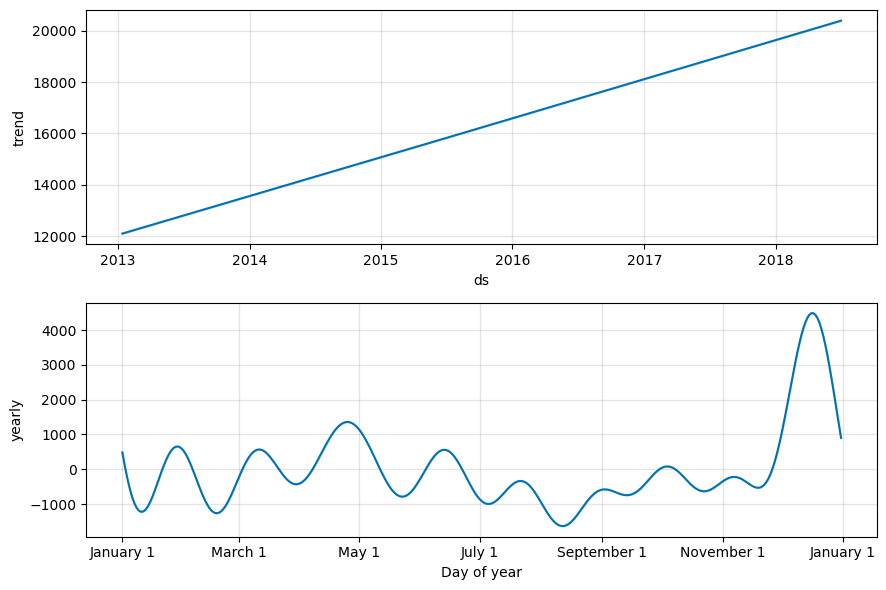

In [25]:
# Plot the components of the model
fig = model.plot_components(forecast)

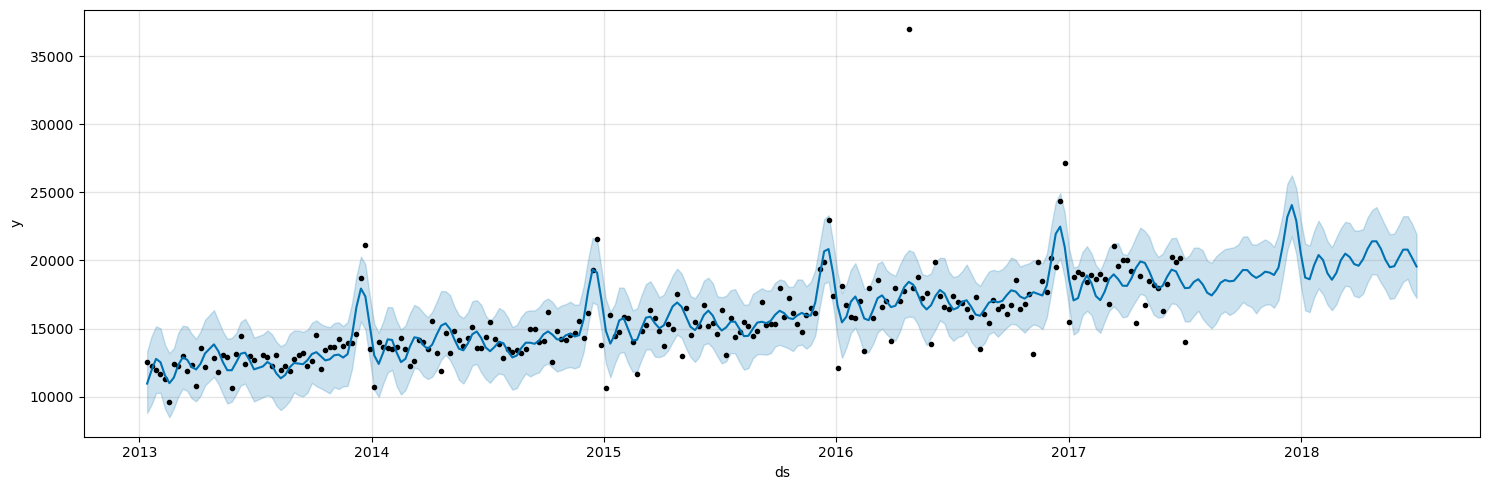

In [26]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(forecast,ax=ax)
plt.show()

In [27]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2013-01-13,12099.10,8797.57,13309.99,12099.10,12099.10,-1140.76,-1140.76,-1140.76,-1140.76,-1140.76,-1140.76,0.00,0.00,0.00,10958.34
1,2013-01-20,12128.07,9418.21,14431.06,12128.07,12128.07,-197.20,-197.20,-197.20,-197.20,-197.20,-197.20,0.00,0.00,0.00,11930.87
2,2013-01-27,12157.04,10262.82,15155.50,12157.04,12157.04,614.59,614.59,614.59,614.59,614.59,614.59,0.00,0.00,0.00,12771.63
3,2013-02-03,12186.02,10280.17,15014.46,12186.02,12186.02,340.00,340.00,340.00,340.00,340.00,340.00,0.00,0.00,0.00,12526.01
4,2013-02-10,12214.99,9119.11,13811.38,12214.99,12214.99,-651.42,-651.42,-651.42,-651.42,-651.42,-651.42,0.00,0.00,0.00,11563.57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279,2018-06-03,20277.92,17814.17,22566.81,20277.05,20278.84,-87.71,-87.71,-87.71,-87.71,-87.71,-87.71,0.00,0.00,0.00,20190.21
280,2018-06-10,20307.11,18425.50,23239.57,20306.21,20308.07,480.50,480.50,480.50,480.50,480.50,480.50,0.00,0.00,0.00,20787.61
281,2018-06-17,20336.30,18645.48,23250.90,20335.37,20337.30,455.52,455.52,455.52,455.52,455.52,455.52,0.00,0.00,0.00,20791.82
282,2018-06-24,20365.49,17779.02,22691.67,20364.53,20366.52,-179.96,-179.96,-179.96,-179.96,-179.96,-179.96,0.00,0.00,0.00,20185.54


In [28]:
# Comparación actuales vs predicciones

X_tst_forecast = model.predict(X_tst_weekly)
X_tst_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
0,2017-07-09,17988.73,15610.09,20610.44
1,2017-07-16,18420.65,16079.24,20778.13
2,2017-07-23,18618.74,16224.19,20960.89
3,2017-07-30,18237.15,15668.96,20435.93
4,2017-08-06,17628.60,15249.76,19963.04


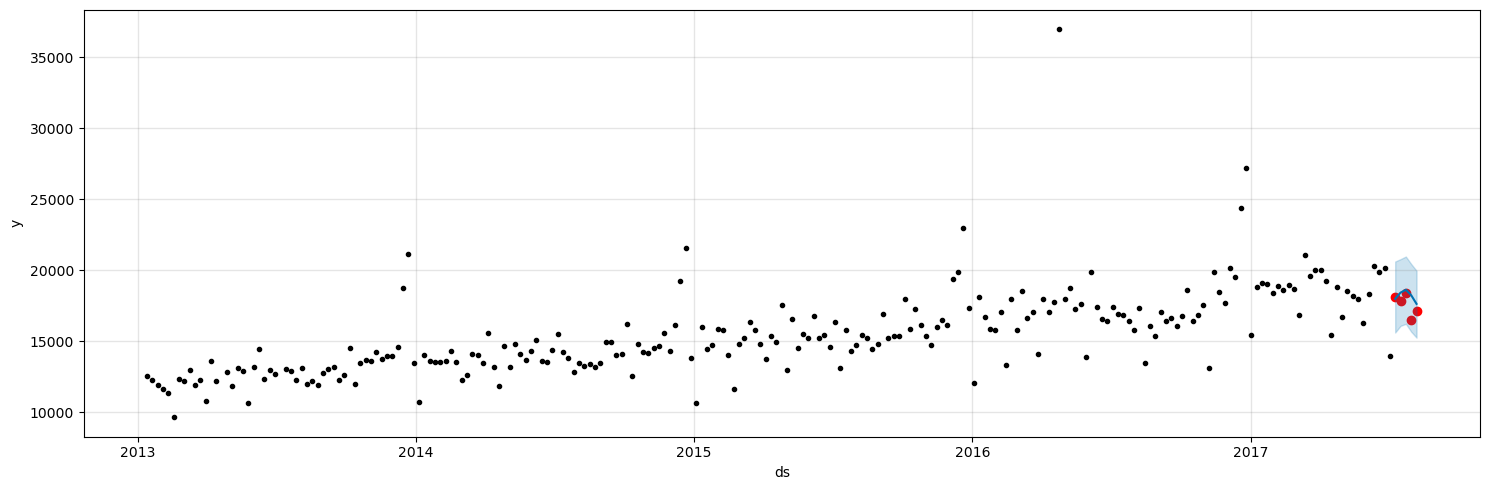

In [29]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(X_tst_weekly.ds, X_tst_weekly['y'], color='r')
fig = model.plot(X_tst_forecast, ax=ax)

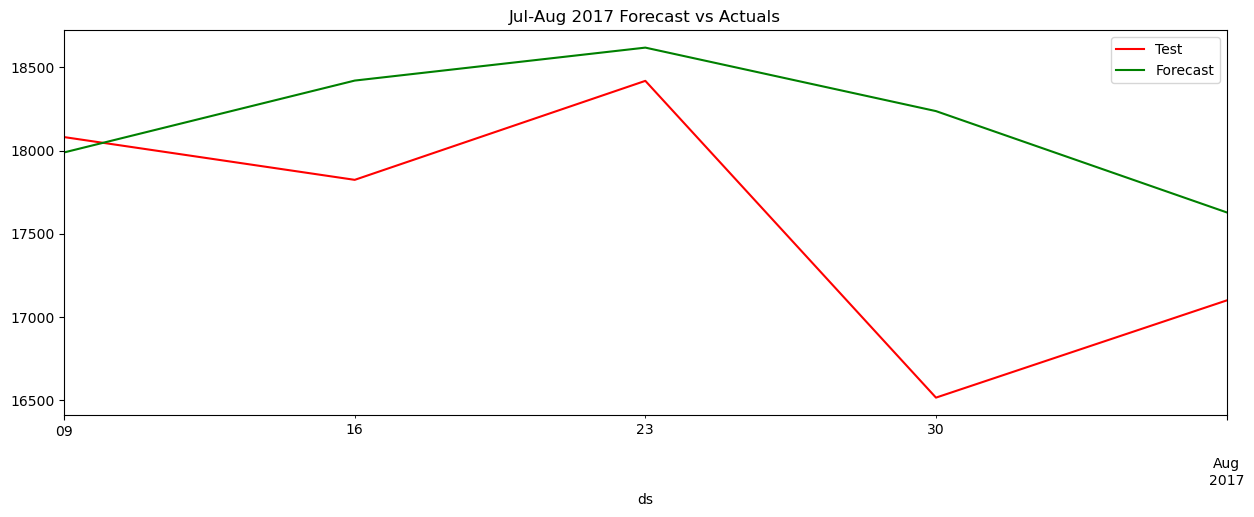

In [30]:
# Comparación ventas de test vs predicciones

f, ax = plt.subplots(figsize=(14,5))
f.set_figheight(5)
f.set_figwidth(15)
X_tst_weekly.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
X_tst_forecast.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Jul-Aug 2017 Forecast vs Actuals')
plt.show()

In [31]:
# Mean Absolute Percentage Error para valores ventas de test vs predicciones

mape = mean_absolute_percentage_error(X_tst_weekly['y'],X_tst_forecast['yhat'])
print("MAPE",round(mape,4))

MAPE 3.6934


In [32]:
params_grid = {'seasonality_mode':('multiplicative','additive'),
               'changepoint_prior_scale':[0.1,0.2,0.3,0.4,0.5],
              'holidays_prior_scale':[0.1,0.2,0.3,0.4,0.5],
              'n_changepoints' : [100,150,200]}
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt+1

print('Total Possible Models',cnt)

Total Possible Models 150


In [33]:
a_df=a_df.resample("W",on='ds').sum()
a_df.reset_index(inplace=True)
a_df=a_df[(a_df['ds']=='2017-07-02') | (a_df['ds']=='2018-07-01')]
a_df =  a_df.rename(columns={'date': 'ds', 'sales': 'y'})

a_df

,ds,y
234,2017-07-02,18080.00


In [34]:
strt='2017-07-02'
end='2017-10-22'
#Actual = a_df[(a_df['ds']>strt) & (a_df['ds']<=end)] # DF Original

model_parameters = pd.DataFrame(columns = ['MAPE','Parameters'])
for p in grid:
    test_final_model = pd.DataFrame()
    print(p)
    random.seed(0)
    train_model =Prophet(changepoint_prior_scale = p['changepoint_prior_scale'],
                         holidays_prior_scale = p['holidays_prior_scale'],
                         n_changepoints = p['n_changepoints'],
                         seasonality_mode = p['seasonality_mode'],
                         weekly_seasonality=True,
                         daily_seasonality = True,
                         yearly_seasonality = True,
                         interval_width=0.95)
    train_model.fit(X_tr_weekly.iloc[:-2,:])
    Actual=a_df.tail(2)
    train_forecast = train_model.make_future_dataframe(periods=52, freq='W',include_history = False)
    train_forecast = train_model.predict(train_forecast)
    test_final_model=train_forecast[['ds','yhat']]
    MAPE = mean_absolute_percentage_error(Actual['y'],abs(test_final_model['yhat']))
    print('Mean Absolute Percentage Error(MAPE)------------------------------------',MAPE)
    model_parameters = model_parameters.append({'MAPE':MAPE,'Parameters':p},ignore_index=True)



10:28:38 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


10:28:38 - cmdstanpy - INFO - Chain [1] done processing
10:28:38 - cmdstanpy - INFO - Chain [1] start processing
10:28:38 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 9.637649435838341
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 9.729008125943396
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


10:28:38 - cmdstanpy - INFO - Chain [1] start processing
10:28:38 - cmdstanpy - INFO - Chain [1] done processing
10:28:39 - cmdstanpy - INFO - Chain [1] start processing
10:28:39 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 9.574727047493667
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 9.638603346494387
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


10:28:39 - cmdstanpy - INFO - Chain [1] start processing
10:28:39 - cmdstanpy - INFO - Chain [1] done processing
10:28:39 - cmdstanpy - INFO - Chain [1] start processing
10:28:39 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 9.518752231101393
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 9.70176255927014
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


10:28:39 - cmdstanpy - INFO - Chain [1] start processing
10:28:39 - cmdstanpy - INFO - Chain [1] done processing
10:28:39 - cmdstanpy - INFO - Chain [1] start processing
10:28:39 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 9.637649435838341
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


10:28:40 - cmdstanpy - INFO - Chain [1] start processing
10:28:40 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 9.729008125943396
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


10:28:40 - cmdstanpy - INFO - Chain [1] start processing
10:28:40 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 9.574727047493667
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


10:28:40 - cmdstanpy - INFO - Chain [1] start processing
10:28:40 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 9.638603346494387
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


10:28:40 - cmdstanpy - INFO - Chain [1] start processing
10:28:40 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 9.518752231101393
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


10:28:41 - cmdstanpy - INFO - Chain [1] start processing
10:28:41 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 9.70176255927014
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 9.637649435838341
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


10:28:41 - cmdstanpy - INFO - Chain [1] start processing
10:28:41 - cmdstanpy - INFO - Chain [1] done processing
10:28:41 - cmdstanpy - INFO - Chain [1] start processing
10:28:41 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 9.729008125943396
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 9.574727047493667
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


10:28:41 - cmdstanpy - INFO - Chain [1] start processing
10:28:41 - cmdstanpy - INFO - Chain [1] done processing
10:28:41 - cmdstanpy - INFO - Chain [1] start processing
10:28:41 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 9.638603346494387
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


10:28:42 - cmdstanpy - INFO - Chain [1] start processing
10:28:42 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 9.518752231101393
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 9.70176255927014
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


10:28:42 - cmdstanpy - INFO - Chain [1] start processing
10:28:42 - cmdstanpy - INFO - Chain [1] done processing
10:28:42 - cmdstanpy - INFO - Chain [1] start processing
10:28:42 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 9.637649435838341
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 9.729008125943396
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


10:28:42 - cmdstanpy - INFO - Chain [1] start processing
10:28:42 - cmdstanpy - INFO - Chain [1] done processing
10:28:42 - cmdstanpy - INFO - Chain [1] start processing
10:28:42 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 9.574727047493667
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 9.638603346494387
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


10:28:43 - cmdstanpy - INFO - Chain [1] start processing
10:28:43 - cmdstanpy - INFO - Chain [1] done processing
10:28:43 - cmdstanpy - INFO - Chain [1] start processing
10:28:43 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 9.518752231101393
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


10:28:43 - cmdstanpy - INFO - Chain [1] start processing
10:28:43 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 9.70176255927014
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 9.637649435838341
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


10:28:43 - cmdstanpy - INFO - Chain [1] start processing
10:28:43 - cmdstanpy - INFO - Chain [1] done processing
10:28:43 - cmdstanpy - INFO - Chain [1] start processing
10:28:43 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 9.729008125943396
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 9.574727047493667
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


10:28:44 - cmdstanpy - INFO - Chain [1] start processing
10:28:44 - cmdstanpy - INFO - Chain [1] done processing
10:28:44 - cmdstanpy - INFO - Chain [1] start processing
10:28:44 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 9.638603346494387
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


10:28:44 - cmdstanpy - INFO - Chain [1] start processing
10:28:44 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 9.518752231101393
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


10:28:44 - cmdstanpy - INFO - Chain [1] start processing
10:28:44 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 9.70176255927014
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 8.112568631929953
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


10:28:45 - cmdstanpy - INFO - Chain [1] start processing
10:28:45 - cmdstanpy - INFO - Chain [1] done processing
10:28:45 - cmdstanpy - INFO - Chain [1] start processing
10:28:45 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 8.449284376720907
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 8.046605095857736
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


10:28:45 - cmdstanpy - INFO - Chain [1] start processing
10:28:45 - cmdstanpy - INFO - Chain [1] done processing
10:28:45 - cmdstanpy - INFO - Chain [1] start processing
10:28:45 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 8.342092452647758
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


10:28:45 - cmdstanpy - INFO - Chain [1] start processing
10:28:45 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 8.092540178672596
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 8.48936207340502
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


10:28:46 - cmdstanpy - INFO - Chain [1] start processing
10:28:46 - cmdstanpy - INFO - Chain [1] done processing
10:28:46 - cmdstanpy - INFO - Chain [1] start processing
10:28:46 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 8.112568631929953
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 8.449284376720907
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


10:28:46 - cmdstanpy - INFO - Chain [1] start processing
10:28:46 - cmdstanpy - INFO - Chain [1] done processing
10:28:46 - cmdstanpy - INFO - Chain [1] start processing
10:28:46 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 8.046605095857736
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


10:28:46 - cmdstanpy - INFO - Chain [1] start processing
10:28:46 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 8.342092452647758
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


10:28:47 - cmdstanpy - INFO - Chain [1] start processing
10:28:47 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 8.092540178672596
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 8.48936207340502
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


10:28:47 - cmdstanpy - INFO - Chain [1] start processing
10:28:47 - cmdstanpy - INFO - Chain [1] done processing
10:28:47 - cmdstanpy - INFO - Chain [1] start processing
10:28:47 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 8.112568631929953
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 8.449284376720907
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


10:28:47 - cmdstanpy - INFO - Chain [1] start processing
10:28:47 - cmdstanpy - INFO - Chain [1] done processing
10:28:47 - cmdstanpy - INFO - Chain [1] start processing
10:28:47 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 8.046605095857736
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 8.342092452647758
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


10:28:48 - cmdstanpy - INFO - Chain [1] start processing
10:28:48 - cmdstanpy - INFO - Chain [1] done processing
10:28:48 - cmdstanpy - INFO - Chain [1] start processing
10:28:48 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 8.092540178672596
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


10:28:48 - cmdstanpy - INFO - Chain [1] start processing
10:28:48 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 8.48936207340502
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


10:28:48 - cmdstanpy - INFO - Chain [1] start processing
10:28:48 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 8.112568631929953
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 8.449284376720907
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


10:28:49 - cmdstanpy - INFO - Chain [1] start processing
10:28:49 - cmdstanpy - INFO - Chain [1] done processing
10:28:49 - cmdstanpy - INFO - Chain [1] start processing
10:28:49 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 8.046605095857736
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 8.342092452647758
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


10:28:49 - cmdstanpy - INFO - Chain [1] start processing
10:28:49 - cmdstanpy - INFO - Chain [1] done processing
10:28:49 - cmdstanpy - INFO - Chain [1] start processing
10:28:49 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 8.092540178672596
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 8.48936207340502
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


10:28:49 - cmdstanpy - INFO - Chain [1] start processing
10:28:49 - cmdstanpy - INFO - Chain [1] done processing
10:28:50 - cmdstanpy - INFO - Chain [1] start processing
10:28:50 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 8.112568631929953
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 8.449284376720907
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


10:28:50 - cmdstanpy - INFO - Chain [1] start processing
10:28:50 - cmdstanpy - INFO - Chain [1] done processing
10:28:50 - cmdstanpy - INFO - Chain [1] start processing
10:28:50 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 8.046605095857736
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


10:28:50 - cmdstanpy - INFO - Chain [1] start processing
10:28:50 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 8.342092452647758
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


10:28:50 - cmdstanpy - INFO - Chain [1] start processing
10:28:51 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 8.092540178672596
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


10:28:51 - cmdstanpy - INFO - Chain [1] start processing
10:28:51 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 8.48936207340502
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 7.037459036013962
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


10:28:51 - cmdstanpy - INFO - Chain [1] start processing
10:28:51 - cmdstanpy - INFO - Chain [1] done processing
10:28:51 - cmdstanpy - INFO - Chain [1] start processing
10:28:51 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 7.655780221764324
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


10:28:51 - cmdstanpy - INFO - Chain [1] start processing
10:28:51 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 7.015898740567311
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 7.742875281106512
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


10:28:52 - cmdstanpy - INFO - Chain [1] start processing
10:28:52 - cmdstanpy - INFO - Chain [1] done processing
10:28:52 - cmdstanpy - INFO - Chain [1] start processing
10:28:52 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 6.852986624783836
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


10:28:52 - cmdstanpy - INFO - Chain [1] start processing
10:28:52 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 7.6361117167962425
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


10:28:52 - cmdstanpy - INFO - Chain [1] start processing
10:28:52 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 7.037459036013962
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 7.655780221764324
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


10:28:53 - cmdstanpy - INFO - Chain [1] start processing
10:28:53 - cmdstanpy - INFO - Chain [1] done processing
10:28:53 - cmdstanpy - INFO - Chain [1] start processing
10:28:53 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 7.015898740567311
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 7.742875281106512
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


10:28:53 - cmdstanpy - INFO - Chain [1] start processing
10:28:53 - cmdstanpy - INFO - Chain [1] done processing
10:28:53 - cmdstanpy - INFO - Chain [1] start processing
10:28:53 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 6.852986624783836
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


10:28:53 - cmdstanpy - INFO - Chain [1] start processing
10:28:53 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 7.6361117167962425
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


10:28:54 - cmdstanpy - INFO - Chain [1] start processing
10:28:54 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 7.037459036013962
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 7.655780221764324
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


10:28:54 - cmdstanpy - INFO - Chain [1] start processing
10:28:54 - cmdstanpy - INFO - Chain [1] done processing
10:28:54 - cmdstanpy - INFO - Chain [1] start processing
10:28:54 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 7.015898740567311
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 7.742875281106512
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


10:28:54 - cmdstanpy - INFO - Chain [1] start processing
10:28:54 - cmdstanpy - INFO - Chain [1] done processing
10:28:55 - cmdstanpy - INFO - Chain [1] start processing
10:28:55 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 6.852986624783836
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


10:28:55 - cmdstanpy - INFO - Chain [1] start processing
10:28:55 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 7.6361117167962425
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 7.037459036013962
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


10:28:55 - cmdstanpy - INFO - Chain [1] start processing
10:28:55 - cmdstanpy - INFO - Chain [1] done processing
10:28:55 - cmdstanpy - INFO - Chain [1] start processing
10:28:55 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 7.655780221764324
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


10:28:55 - cmdstanpy - INFO - Chain [1] start processing
10:28:55 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 7.015898740567311
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


10:28:56 - cmdstanpy - INFO - Chain [1] start processing
10:28:56 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 7.742875281106512
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


10:28:56 - cmdstanpy - INFO - Chain [1] start processing
10:28:56 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 6.852986624783836
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 7.6361117167962425
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


10:28:56 - cmdstanpy - INFO - Chain [1] start processing
10:28:56 - cmdstanpy - INFO - Chain [1] done processing
10:28:56 - cmdstanpy - INFO - Chain [1] start processing
10:28:56 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 7.037459036013962
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 7.655780221764324
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


10:28:56 - cmdstanpy - INFO - Chain [1] start processing
10:28:56 - cmdstanpy - INFO - Chain [1] done processing
10:28:57 - cmdstanpy - INFO - Chain [1] start processing
10:28:57 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 7.015898740567311
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 7.742875281106512
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


10:28:57 - cmdstanpy - INFO - Chain [1] start processing
10:28:57 - cmdstanpy - INFO - Chain [1] done processing
10:28:57 - cmdstanpy - INFO - Chain [1] start processing
10:28:57 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 6.852986624783836
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 7.6361117167962425
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


10:28:57 - cmdstanpy - INFO - Chain [1] start processing
10:28:58 - cmdstanpy - INFO - Chain [1] done processing
10:28:58 - cmdstanpy - INFO - Chain [1] start processing
10:28:58 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 10.62803159232573
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 7.20160124327476
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


10:28:58 - cmdstanpy - INFO - Chain [1] start processing
10:28:58 - cmdstanpy - INFO - Chain [1] done processing
10:28:58 - cmdstanpy - INFO - Chain [1] start processing
10:28:58 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 6.379216417080498
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 7.239980186932074
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


10:28:59 - cmdstanpy - INFO - Chain [1] start processing
10:28:59 - cmdstanpy - INFO - Chain [1] done processing
10:28:59 - cmdstanpy - INFO - Chain [1] start processing
10:28:59 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 6.611397407630968
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 7.10531275569212
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


10:28:59 - cmdstanpy - INFO - Chain [1] start processing
10:28:59 - cmdstanpy - INFO - Chain [1] done processing
10:29:00 - cmdstanpy - INFO - Chain [1] start processing
10:29:00 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 10.62803159232573
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


10:29:00 - cmdstanpy - INFO - Chain [1] start processing
10:29:00 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 7.20160124327476
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


10:29:00 - cmdstanpy - INFO - Chain [1] start processing
10:29:00 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 6.379216417080498
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


10:29:00 - cmdstanpy - INFO - Chain [1] start processing
10:29:00 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 7.239980186932074
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


10:29:01 - cmdstanpy - INFO - Chain [1] start processing
10:29:01 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 6.611397407630968
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


10:29:01 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 7.10531275569212
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


10:29:01 - cmdstanpy - INFO - Chain [1] done processing
10:29:02 - cmdstanpy - INFO - Chain [1] start processing
10:29:02 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 10.62803159232573
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 7.20160124327476
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


10:29:02 - cmdstanpy - INFO - Chain [1] start processing
10:29:02 - cmdstanpy - INFO - Chain [1] done processing
10:29:02 - cmdstanpy - INFO - Chain [1] start processing
10:29:02 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 6.379216417080498
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 7.239980186932074
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


10:29:02 - cmdstanpy - INFO - Chain [1] start processing
10:29:02 - cmdstanpy - INFO - Chain [1] done processing
10:29:02 - cmdstanpy - INFO - Chain [1] start processing
10:29:02 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 6.611397407630968
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


10:29:03 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 7.10531275569212
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


10:29:03 - cmdstanpy - INFO - Chain [1] done processing
10:29:03 - cmdstanpy - INFO - Chain [1] start processing
10:29:03 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 10.62803159232573
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


10:29:04 - cmdstanpy - INFO - Chain [1] start processing
10:29:04 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 7.20160124327476
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


10:29:04 - cmdstanpy - INFO - Chain [1] start processing
10:29:04 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 6.379216417080498
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 7.239980186932074
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


10:29:04 - cmdstanpy - INFO - Chain [1] start processing
10:29:04 - cmdstanpy - INFO - Chain [1] done processing
10:29:04 - cmdstanpy - INFO - Chain [1] start processing
10:29:04 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 6.611397407630968
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 7.10531275569212
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


10:29:04 - cmdstanpy - INFO - Chain [1] start processing
10:29:05 - cmdstanpy - INFO - Chain [1] done processing
10:29:05 - cmdstanpy - INFO - Chain [1] start processing
10:29:05 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 10.62803159232573
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


10:29:05 - cmdstanpy - INFO - Chain [1] start processing
10:29:05 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 7.20160124327476
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


10:29:05 - cmdstanpy - INFO - Chain [1] start processing
10:29:05 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 6.379216417080498
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


10:29:06 - cmdstanpy - INFO - Chain [1] start processing
10:29:06 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 7.239980186932074
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


10:29:06 - cmdstanpy - INFO - Chain [1] start processing
10:29:06 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 6.611397407630968
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 7.10531275569212
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


10:29:06 - cmdstanpy - INFO - Chain [1] start processing
10:29:07 - cmdstanpy - INFO - Chain [1] done processing
10:29:07 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 9.72270443497165
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


10:29:08 - cmdstanpy - INFO - Chain [1] done processing
10:29:08 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 6.867296523755617
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


10:29:09 - cmdstanpy - INFO - Chain [1] done processing
10:29:09 - cmdstanpy - INFO - Chain [1] start processing
10:29:09 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 10.653434508235149
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


10:29:09 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 6.80176387752594
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


10:29:10 - cmdstanpy - INFO - Chain [1] done processing
10:29:10 - cmdstanpy - INFO - Chain [1] start processing
10:29:10 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 10.407617707899638
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


10:29:10 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 6.884480413622257
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


10:29:11 - cmdstanpy - INFO - Chain [1] done processing
10:29:11 - cmdstanpy - INFO - Chain [1] start processing
10:29:11 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 9.72270443497165
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 6.867296523755617
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


10:29:11 - cmdstanpy - INFO - Chain [1] start processing
10:29:12 - cmdstanpy - INFO - Chain [1] done processing
10:29:12 - cmdstanpy - INFO - Chain [1] start processing
10:29:12 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 10.653434508235149
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 6.80176387752594
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


10:29:12 - cmdstanpy - INFO - Chain [1] start processing
10:29:13 - cmdstanpy - INFO - Chain [1] done processing
10:29:13 - cmdstanpy - INFO - Chain [1] start processing
10:29:13 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 10.407617707899638
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


10:29:13 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 6.884480413622257
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


10:29:14 - cmdstanpy - INFO - Chain [1] done processing
10:29:14 - cmdstanpy - INFO - Chain [1] start processing
10:29:14 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 9.72270443497165
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 6.867296523755617
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


10:29:14 - cmdstanpy - INFO - Chain [1] start processing
10:29:15 - cmdstanpy - INFO - Chain [1] done processing
10:29:15 - cmdstanpy - INFO - Chain [1] start processing
10:29:15 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 10.653434508235149
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


10:29:15 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 6.80176387752594
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


10:29:16 - cmdstanpy - INFO - Chain [1] done processing
10:29:16 - cmdstanpy - INFO - Chain [1] start processing
10:29:16 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 10.407617707899638
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


10:29:16 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 6.884480413622257
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


10:29:17 - cmdstanpy - INFO - Chain [1] done processing
10:29:17 - cmdstanpy - INFO - Chain [1] start processing
10:29:17 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 9.72270443497165
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


10:29:17 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 6.867296523755617
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


10:29:18 - cmdstanpy - INFO - Chain [1] done processing
10:29:18 - cmdstanpy - INFO - Chain [1] start processing
10:29:18 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 10.653434508235149
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 6.80176387752594
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


10:29:18 - cmdstanpy - INFO - Chain [1] start processing
10:29:19 - cmdstanpy - INFO - Chain [1] done processing
10:29:19 - cmdstanpy - INFO - Chain [1] start processing
10:29:19 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 10.407617707899638
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


10:29:19 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 6.884480413622257
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


10:29:20 - cmdstanpy - INFO - Chain [1] done processing
10:29:20 - cmdstanpy - INFO - Chain [1] start processing
10:29:20 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 9.72270443497165
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 6.867296523755617
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


10:29:20 - cmdstanpy - INFO - Chain [1] start processing
10:29:21 - cmdstanpy - INFO - Chain [1] done processing
10:29:21 - cmdstanpy - INFO - Chain [1] start processing
10:29:21 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 10.653434508235149
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


10:29:21 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 6.80176387752594
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


10:29:22 - cmdstanpy - INFO - Chain [1] done processing
10:29:22 - cmdstanpy - INFO - Chain [1] start processing
10:29:22 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 10.407617707899638
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 6.884480413622257


In [35]:
parameters = model_parameters.sort_values(by=['MAPE'])
parameters = parameters.reset_index(drop=True)
parameters.head()

,MAPE,Parameters
0,6.38,"{'changepoint_prior_scale': 0.4, 'holidays_pri..."
1,6.38,"{'changepoint_prior_scale': 0.4, 'holidays_pri..."
2,6.38,"{'changepoint_prior_scale': 0.4, 'holidays_pri..."
3,6.38,"{'changepoint_prior_scale': 0.4, 'holidays_pri..."
4,6.38,"{'changepoint_prior_scale': 0.4, 'holidays_pri..."


In [36]:
parameters['Parameters'][0]

{'changepoint_prior_scale': 0.4,
 'holidays_prior_scale': 0.5,
 'n_changepoints': 150,
 'seasonality_mode': 'multiplicative'}

In [37]:
# Setup and train final model
final_weekly_model = Prophet(changepoint_prior_scale= 0.5,
                      holidays_prior_scale = 0.5,
                      n_changepoints = 150,
                      seasonality_mode = 'additive',                      
                      weekly_seasonality=True,
                      daily_seasonality = True,
                      yearly_seasonality = True,
                      interval_width=0.95)
final_weekly_model.fit(X_tr_weekly)

10:29:22 - cmdstanpy - INFO - Chain [1] start processing
10:29:22 - cmdstanpy - INFO - Chain [1] done processing


In [38]:
future = final_weekly_model.make_future_dataframe(periods=52, freq='W')
forecast = final_weekly_model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
277,2018-05-20,18680.35,15026.26,22499.60
278,2018-05-27,18742.78,15216.72,22231.99
279,2018-06-03,19347.03,15580.70,22874.89
280,2018-06-10,19935.52,16095.47,23844.26
281,2018-06-17,19934.88,16487.34,23774.66
282,2018-06-24,19320.73,15749.51,23086.64
283,2018-07-01,18665.86,15079.05,22233.19


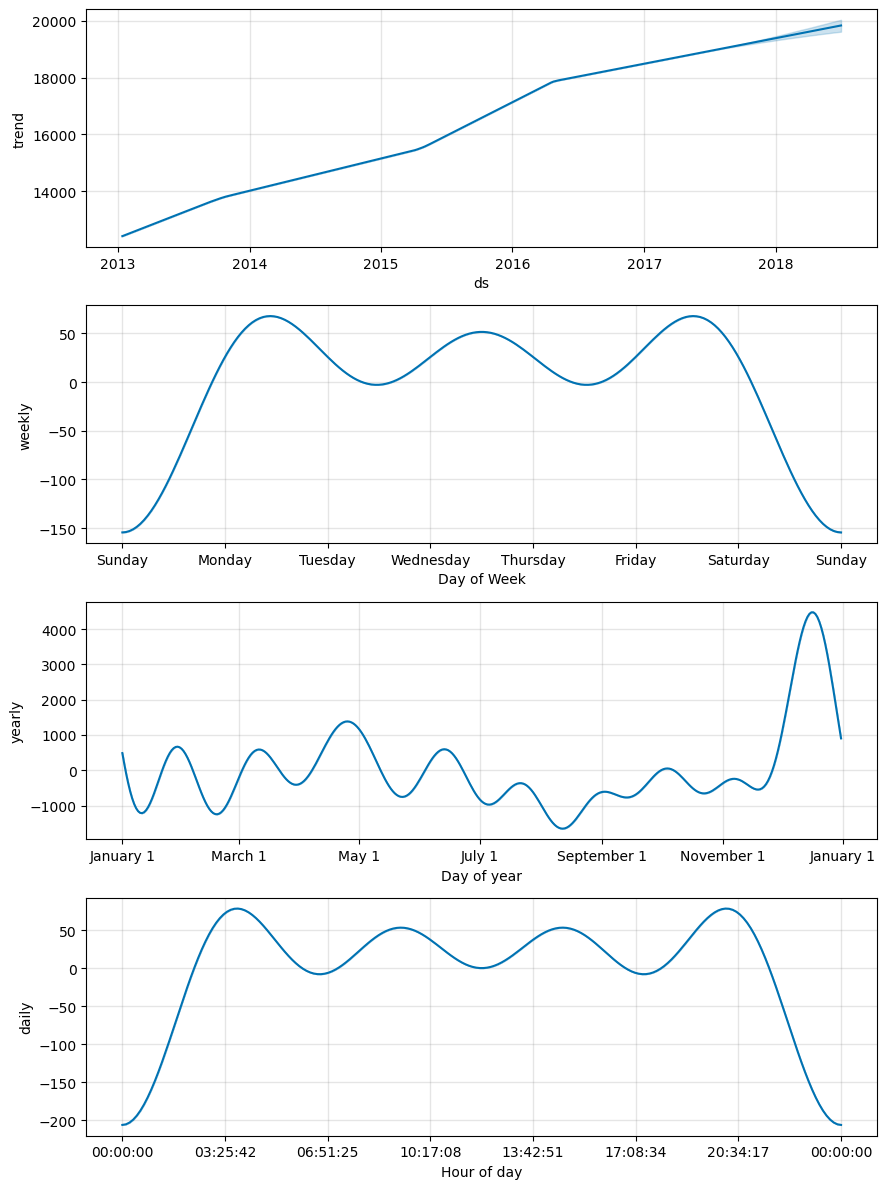

In [39]:
# Plot the components of the model
fig = final_weekly_model.plot_components(forecast)

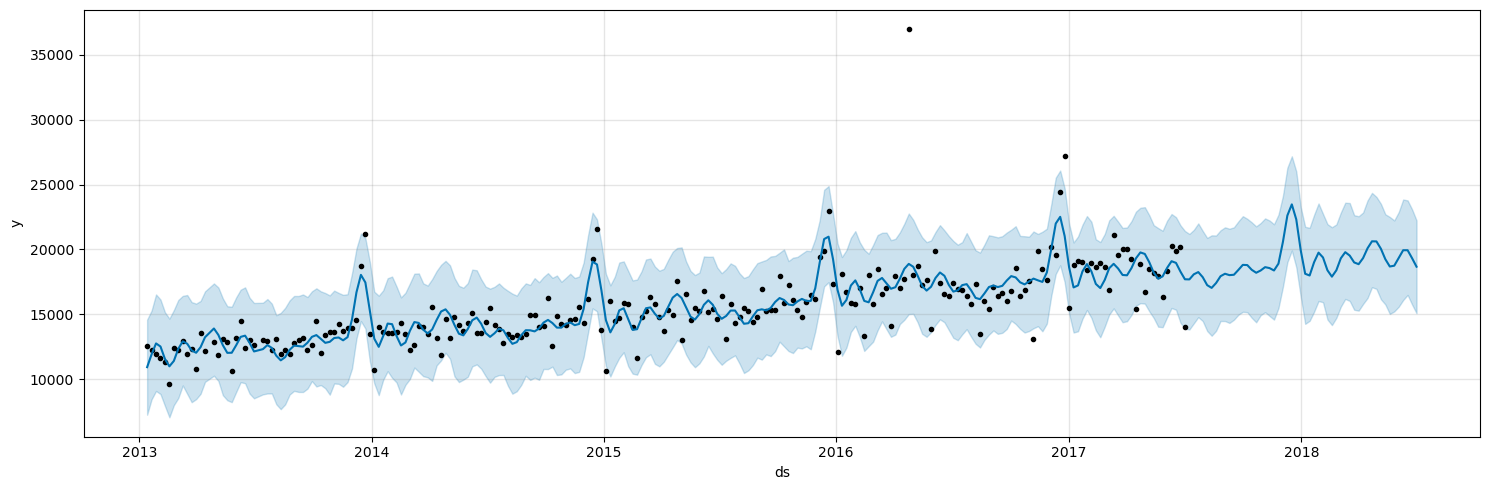

In [40]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = final_weekly_model.plot(forecast,ax=ax)
plt.show()

In [41]:
X_tst_final= final_weekly_model.predict(X_tst_weekly)
X_tst_final[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
0,2017-07-09,17685.73,14232.98,21061.61
1,2017-07-16,18080.05,14565.92,21422.30
2,2017-07-23,18251.42,14782.90,21799.21
3,2017-07-30,17857.23,14431.17,21290.28
4,2017-08-06,17242.64,13780.62,20909.52


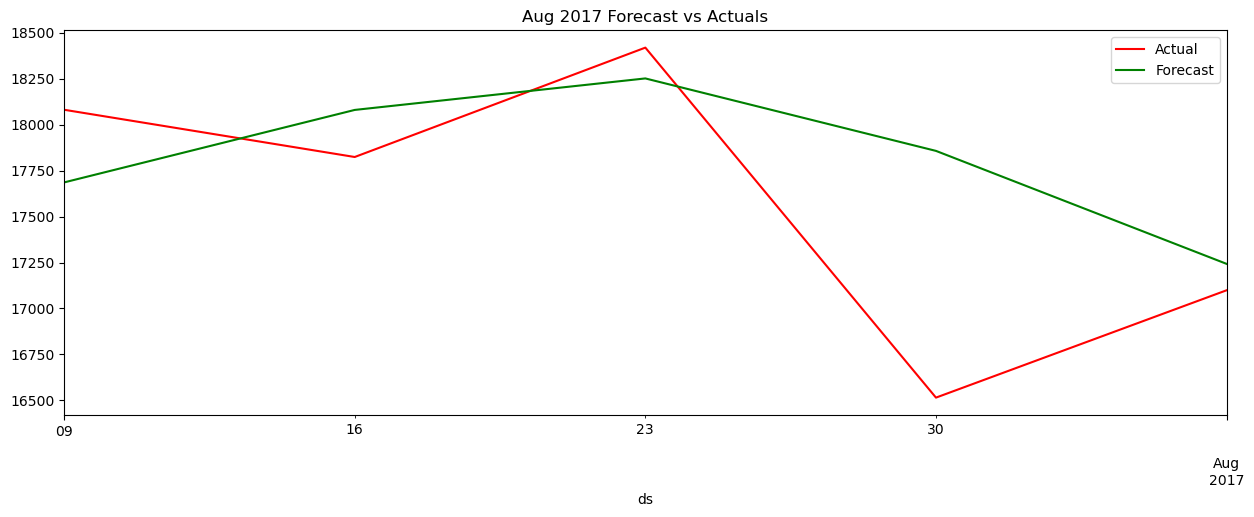

In [42]:
f, ax = plt.subplots(figsize=(14,5))
f.set_figheight(5)
f.set_figwidth(15)
X_tst_weekly.plot(kind='line',x='ds', y='y', color='red', label='Actual', ax=ax)
X_tst_final.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Aug 2017 Forecast vs Actuals')
plt.show()

In [43]:
MAPE = mean_absolute_percentage_error(X_tst_weekly['y'],abs(X_tst_final['yhat']))
print('MAPE', MAPE)

MAPE 2.6999795771782282


In [44]:
def root_mean_squared_error(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    return np.sqrt(mse)


In [45]:
rmse = root_mean_squared_error(X_tst_weekly['y'], X_tst_final['yhat'])
print('RMSE', rmse)

RMSE 643.7553085079987


In [46]:
forecast = forecast[['ds',
                     'yhat',
                     'yhat_lower',
                     'yhat_upper']]

In [47]:
forecast

,ds,yhat,yhat_lower,yhat_upper
0,2013-01-13,10922.11,7254.29,14586.43
1,2013-01-20,11902.83,8441.25,15280.00
2,2013-01-27,12752.05,9086.24,16529.27
3,2013-02-03,12513.62,8848.24,16133.16
4,2013-02-10,11556.42,7935.01,15152.15
...,...,...,...,...
279,2018-06-03,19347.03,15580.70,22874.89
280,2018-06-10,19935.52,16095.47,23844.26
281,2018-06-17,19934.88,16487.34,23774.66
282,2018-06-24,19320.73,15749.51,23086.64


In [48]:
modelo_entrenado_ventas_semanal = forecast

# Guardar el modelo en un archivo .pkl
with open('modelo_entrenado_ventas_semanal.pkl', 'wb') as archivo:
    pickle.dump(modelo_entrenado_ventas_semanal, archivo)


In [49]:
# Cargar el modelo desde el archivo .pkl
#with open('modelo_entrenado_ventas_semanal.pkl', 'rb') as archivo:
 #   modelo_cargado = pickle.load(archivo)